<a href="https://colab.research.google.com/github/bill7845/colab_repo/blob/master/dacon_%ED%8E%80%EB%8B%A4/%ED%8E%80%EB%8B%A4_NOTE_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 

In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dacon_펀다/funda_train.csv')
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dacon_펀다/submission.csv')

In [0]:
train.head(3)

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000


In [0]:
## 상점 갯수

train.store_id.nunique()

1967

In [0]:
# 업종별 매출을 살펴보자
train.groupby('type_of_business')['amount'].agg(['sum','mean','std']).sort_values(by='mean',ascending=False)

,sum,mean,std
type_of_business,,,
의약품 도매업,1.568540e+09,354632.638674,455046.472963
기타 산업용 농산물 도매업,3.189488e+08,276625.139388,297476.619589
경영 컨설팅업,9.516713e+07,150819.538148,196114.489375
일반 병원,3.609477e+08,135287.727565,90847.339946
"주방용품 및 가정용 유리, 요업 제품 소매업",5.284146e+07,95901.011149,142404.188224
...,...,...,...
비알코올 음료점업,1.432737e+08,1970.210406,13852.538387
떡류 제조업,1.046651e+07,1825.979464,4166.517423
체인화 편의점,3.871520e+06,1593.218107,2865.938897


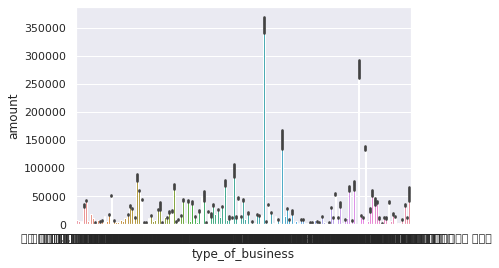

In [0]:
# sns.barplot(
#     data= train,
#     x= "type_of_business",
#     y= "amount"
# )
# plt.show()

In [0]:
# 상점별 마지막시점으로부터의 3개월 기간의 매출을 예측해야한다. (3개월 총 매출)
# 마지막 시점 이전 기간의 데이터가 input으로 활용될것이므로 데이터를 시간별로 정리해두어야 한다

In [0]:
# date,time => python datetime 형식으로 변경
train['datetime'] = train['transacted_date'] + train['transacted_time']

# date,time col 합쳐서 datetime으로
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d%H:%M', errors='raise')

# datetime을 인덱스로
train.set_index('datetime',inplace=True)
del train['transacted_date']
del train['transacted_time']

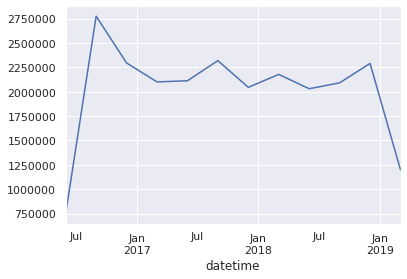

In [0]:
train.loc[train.store_id == 0].resample('3M')['amount'].sum().plot()

In [0]:
# 상점별 3개월 매출총합을 예측하는것이 목표이다. 언뜻보기에 쓸만한 변수는 amount밖에 없어보인다.
# 업종별 매출 추세?를 구해 파생변수를 만들어 볼 수 있지 않을까
# 지역별 경기도 파생변수로?..


In [0]:
## 거래취소에 대한 전처리

# 두 가지 경우가 있다. 1.전액환불인 경우 2.일부환불(환급?)인 경우
# 전액환불의 경우 처리가 가능하나 일부환불/환급에 대한 처리가 어렵다..
# 우선 전액환불인 경우는 제거한다

In [0]:
# train_copy = train.copy().reset_index() # index를 사용해야함 

# def remove_transaction_cancel(df): 
#   train_neg = df[df.amount < 0] # 정상거래
#   train_pos = df[df.amount > 0] # 거래취소 (전액/일부)

#   tmp_index = [] 
#   tmp_index_2 = []

#   for neg_i in train_neg.to_records()[:]: # to_records() => 데이터프레임을 ndarray형태로 바꾸어준다

#     neg_index_i = neg_i[0] # i번째 취소거래에 대한 index
#     neg_date_i = neg_i[1] # i번째 취소거래에 대한 date
#     neg_store_i = neg_i[2] # i번째 취소거래에 대한 store_id
#     neg_card_i = neg_i[3] # i번째 취소거래에 대한 card_id
#     neg_amount_i = neg_i[8] # i번째 취소거래에 대한 amount

#     pos_i = train_pos[train_pos['store_id'] == neg_store_i] # 정상거래 중 i번째 취소거래와 상점아이디 같은 경우만
#     pos_i = pos_i[pos_i['card_id'] == neg_card_i] # 그리고 그 중 i번째 card_id도 같은 경우만
#     pos_i = pos_i[pos_i.index < neg_index_i] # 마지막으로 그 중에서 index가 i번째 취소거래 이전인 경우만 # 취소거래 이전
#     # date를 사용할 경우 같은 시간대에 결제/환불이 이루어진 경우 때문에 잘 걸러내지 못한다

#     if len(pos_i[pos_i['amount'] == abs(neg_amount_i)]) > 0 : # 그 중에서 i번째 취소거래의 절대값과 같은 정상거래가 있다면 
#       tmp_index.append(max(pos_i.index)) # 정상거래 중 i번째 취소거래와 가장 가까운 경우의 index를 가져간다
#       tmp_index_2.append(neg_index_i) # 해당 취소거래의 index를 가져간다

#   res_list = tmp_index + tmp_index_2 # 결제취소 데이터의 index를 모두 담는다 

#   df = df.loc[~df.index.isin(res_list),:]      

#   return df



# train_copy = remove_transaction_cancel(train_copy) # 결제취소 데이터 삭제
# train_copy.to_csv('preprocessing_1_거래취소.csv')

In [0]:
train_copy = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dacon_펀다/preprocessing/preprocessing_1_거래취소.csv',index_col='datetime',parse_dates=True)
del train_copy['Unnamed: 0']

In [0]:
sample = train_copy.query("store_id == 151") # stor_id 0으로 sampling

In [0]:
train_copy[train_copy.store_id == 151].head(1)

,store_id,card_id,card_company,installment_term,region,type_of_business,amount
datetime,,,,,,,
2016-06-01 17:19:00,151,335172,a,0,인천 남구,의복 소매업,4285.714286


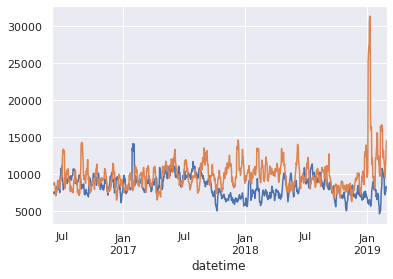

In [0]:
# 지표를 추가해보자

# 업종별 일주일간 매출 평균 추세
# store_id 0의 업종인 기타미용업으로 진행해본다
train_copy[train_copy.type_of_business == "기타 미용업"]['amount'].resample('D').mean().rolling(7).mean().plot()


# 지역별 일주일간 매출 추세
train_copy[train_copy.region == "인천 남구"]['amount'].resample('D').mean().rolling(7).mean().plot()